In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

2023-04-26 10:48:49.917065: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 10:48:49.940008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 10:48:50.060429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 10:48:50.060985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 10:48:50.774765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data")):
    print(folder)
    for im in tqdm(os.listdir("data/"+folder+"/images/")):
        if folder == "clean":
            clean.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_anomalies.append(1)
        else:
          test.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_test.append(mapping[int(im[0])])
    ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                   

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:22<01:06, 22.10s/it]

jammed_channel



 50%|█████     | 2/4 [00:24<00:21, 10.72s/it]

clean_validation



 75%|███████▌  | 3/4 [00:27<00:07,  7.16s/it]

test



100%|██████████| 4/4 [00:32<00:00,  8.23s/it]


In [6]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [13]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense) 

Summary of the encoder:



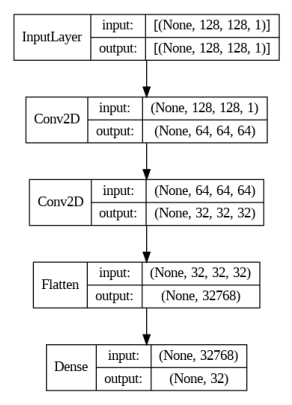

Summary of the decoder:



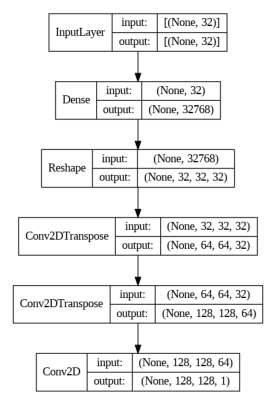

In [7]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [15]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 8s 48ms/step - loss: 0.0428 - val_loss: 0.0359
Epoch 2/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0351 - val_loss: 0.0353
Epoch 3/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0344 - val_loss: 0.0337
Epoch 4/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0311 - val_loss: 0.0293
Epoch 5/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0284 - val_loss: 0.0282
Epoch 6/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0279 - val_loss: 0.0280
Epoch 7/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0277 - val_loss: 0.0279
Epoch 8/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 9/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 10/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0276 - val_lo

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

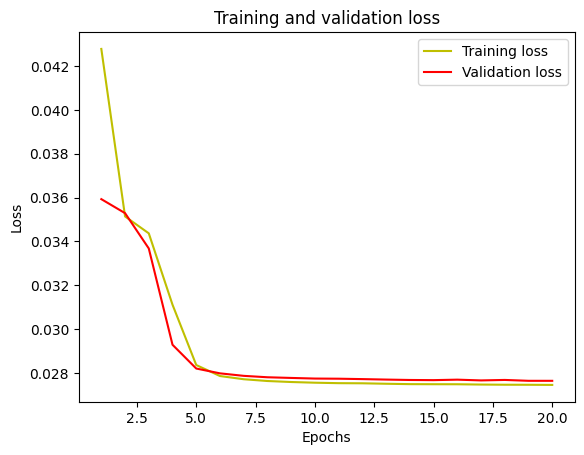

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 0s 20ms/step


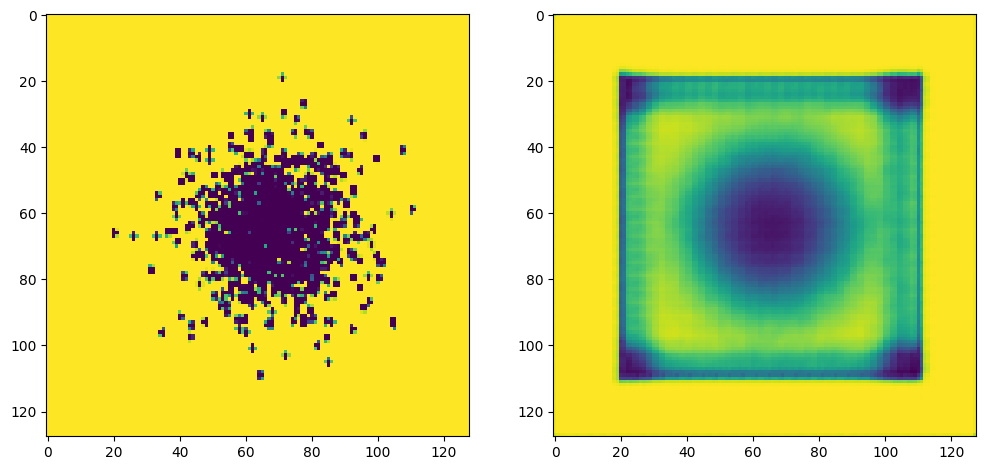

In [38]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [27]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 41ms/step - loss: 0.0483
Validation error 0.027643820270895958
Anomaly error 0.048263467848300934
The reconstruction error of the jammed channel is  1.7459044146338127  more than the clean channel


In [28]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [29]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 195ms/step - loss: 0.0269


  0%|          | 1/600 [00:00<02:33,  3.90it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


  0%|          | 2/600 [00:00<01:45,  5.64it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0236


  0%|          | 3/600 [00:00<01:25,  6.94it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0277


  1%|          | 5/600 [00:00<01:11,  8.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0298


  1%|          | 6/600 [00:00<01:08,  8.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0292


  1%|          | 7/600 [00:00<01:06,  8.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


  2%|▏         | 9/600 [00:01<01:00,  9.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0287


  2%|▏         | 11/600 [00:01<00:52, 11.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


  2%|▏         | 13/600 [00:01<00:48, 12.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


  2%|▎         | 15/600 [00:01<00:46, 12.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0278


  3%|▎         | 17/600 [00:01<00:43, 13.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


  3%|▎         | 19/600 [00:01<00:41, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0262


  4%|▎         | 21/600 [00:01<00:40, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


  4%|▍         | 23/600 [00:02<00:39, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0255


  4%|▍         | 25/600 [00:02<00:38, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


  4%|▍         | 27/600 [00:02<00:39, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


  5%|▍         | 29/600 [00:02<00:37, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


  5%|▌         | 31/600 [00:02<00:38, 14.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


  6%|▌         | 33/600 [00:02<00:39, 14.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


  6%|▌         | 35/600 [00:02<00:38, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


  6%|▌         | 37/600 [00:02<00:39, 14.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


  6%|▋         | 39/600 [00:03<00:38, 14.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0289


  7%|▋         | 41/600 [00:03<00:38, 14.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0275


  7%|▋         | 43/600 [00:03<00:37, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


  8%|▊         | 45/600 [00:03<00:37, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


  8%|▊         | 47/600 [00:03<00:37, 14.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0251


  8%|▊         | 49/600 [00:03<00:36, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


  8%|▊         | 51/600 [00:03<00:36, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0270


  9%|▉         | 53/600 [00:04<00:35, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


  9%|▉         | 55/600 [00:04<00:35, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 10%|▉         | 57/600 [00:04<00:35, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0258


 10%|▉         | 59/600 [00:04<00:35, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 10%|█         | 61/600 [00:04<00:34, 15.44it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0278


 10%|█         | 63/600 [00:04<00:35, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 11%|█         | 65/600 [00:04<00:35, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 11%|█         | 67/600 [00:04<00:37, 14.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 12%|█▏        | 69/600 [00:05<00:37, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 12%|█▏        | 71/600 [00:05<00:37, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 12%|█▏        | 73/600 [00:05<00:37, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0240


 12%|█▎        | 75/600 [00:05<00:37, 14.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0257


 13%|█▎        | 77/600 [00:05<00:37, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 13%|█▎        | 79/600 [00:05<00:38, 13.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0252


 14%|█▎        | 81/600 [00:06<00:38, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 14%|█▍        | 83/600 [00:06<00:39, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 14%|█▍        | 85/600 [00:06<00:38, 13.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 14%|█▍        | 87/600 [00:06<00:37, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 15%|█▍        | 89/600 [00:06<00:36, 13.83it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0286


 15%|█▌        | 91/600 [00:06<00:36, 13.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 16%|█▌        | 93/600 [00:06<00:36, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 16%|█▌        | 95/600 [00:07<00:35, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 16%|█▌        | 97/600 [00:07<00:34, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 16%|█▋        | 99/600 [00:07<00:34, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 17%|█▋        | 101/600 [00:07<00:34, 14.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0292


 17%|█▋        | 103/600 [00:07<00:35, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 18%|█▊        | 105/600 [00:07<00:33, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 18%|█▊        | 107/600 [00:07<00:34, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 18%|█▊        | 109/600 [00:07<00:34, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


 18%|█▊        | 111/600 [00:08<00:33, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 19%|█▉        | 113/600 [00:08<00:33, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 19%|█▉        | 115/600 [00:08<00:33, 14.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 20%|█▉        | 117/600 [00:08<00:32, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


 20%|█▉        | 119/600 [00:08<00:33, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 20%|██        | 121/600 [00:08<00:33, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 20%|██        | 123/600 [00:08<00:34, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 21%|██        | 125/600 [00:09<00:33, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 21%|██        | 127/600 [00:09<00:33, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0231


 22%|██▏       | 129/600 [00:09<00:32, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 22%|██▏       | 131/600 [00:09<00:31, 14.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0225


 22%|██▏       | 133/600 [00:09<00:32, 14.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 22%|██▎       | 135/600 [00:09<00:32, 14.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


 23%|██▎       | 137/600 [00:09<00:32, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0236


 23%|██▎       | 139/600 [00:10<00:31, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 24%|██▎       | 141/600 [00:10<00:31, 14.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0247


 24%|██▍       | 143/600 [00:10<00:31, 14.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0307


 24%|██▍       | 145/600 [00:10<00:32, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 24%|██▍       | 147/600 [00:10<00:32, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


 25%|██▍       | 149/600 [00:10<00:32, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0261


 25%|██▌       | 151/600 [00:10<00:33, 13.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0284


 26%|██▌       | 153/600 [00:11<00:33, 13.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0236


 26%|██▌       | 155/600 [00:11<00:35, 12.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0320


 26%|██▌       | 157/600 [00:11<00:38, 11.65it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0280


 26%|██▋       | 159/600 [00:11<00:39, 11.18it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0283


 27%|██▋       | 161/600 [00:11<00:41, 10.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0292


 27%|██▋       | 163/600 [00:12<00:41, 10.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0271


 28%|██▊       | 165/600 [00:12<00:42, 10.16it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0287


 28%|██▊       | 167/600 [00:12<00:42, 10.11it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0239


 28%|██▊       | 169/600 [00:12<00:42, 10.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0249


 28%|██▊       | 171/600 [00:12<00:41, 10.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0273


 29%|██▉       | 173/600 [00:13<00:41, 10.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0266


 29%|██▉       | 175/600 [00:13<00:40, 10.54it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0268


 30%|██▉       | 177/600 [00:13<00:40, 10.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 30%|██▉       | 179/600 [00:13<00:37, 11.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 30%|███       | 181/600 [00:13<00:35, 11.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 30%|███       | 183/600 [00:13<00:32, 12.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0259


 31%|███       | 185/600 [00:14<00:31, 13.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0246


 31%|███       | 187/600 [00:14<00:30, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 32%|███▏      | 189/600 [00:14<00:30, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 32%|███▏      | 191/600 [00:14<00:30, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 32%|███▏      | 193/600 [00:14<00:29, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 32%|███▎      | 195/600 [00:14<00:29, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 33%|███▎      | 197/600 [00:14<00:28, 14.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0254


 33%|███▎      | 199/600 [00:14<00:28, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 34%|███▎      | 201/600 [00:15<00:27, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0251


 34%|███▍      | 203/600 [00:15<00:28, 14.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 34%|███▍      | 205/600 [00:15<00:28, 13.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 34%|███▍      | 207/600 [00:15<00:27, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 35%|███▍      | 209/600 [00:15<00:27, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 35%|███▌      | 211/600 [00:15<00:26, 14.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0285


 36%|███▌      | 213/600 [00:15<00:27, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 36%|███▌      | 215/600 [00:16<00:26, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0231


 36%|███▌      | 217/600 [00:16<00:25, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 36%|███▋      | 219/600 [00:16<00:26, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0278


 37%|███▋      | 221/600 [00:16<00:27, 13.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 37%|███▋      | 223/600 [00:16<00:27, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 38%|███▊      | 225/600 [00:16<00:25, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 38%|███▊      | 227/600 [00:16<00:25, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 38%|███▊      | 229/600 [00:17<00:26, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 38%|███▊      | 231/600 [00:17<00:26, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 39%|███▉      | 233/600 [00:17<00:26, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 39%|███▉      | 235/600 [00:17<00:26, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 40%|███▉      | 237/600 [00:17<00:25, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 40%|███▉      | 239/600 [00:17<00:25, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 40%|████      | 241/600 [00:17<00:25, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 40%|████      | 243/600 [00:18<00:24, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0275


 41%|████      | 245/600 [00:18<00:24, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 41%|████      | 247/600 [00:18<00:24, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0230


 42%|████▏     | 249/600 [00:18<00:23, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 42%|████▏     | 251/600 [00:18<00:23, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0221


 42%|████▏     | 253/600 [00:18<00:23, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


 42%|████▎     | 255/600 [00:18<00:23, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0259


 43%|████▎     | 257/600 [00:19<00:23, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 43%|████▎     | 259/600 [00:19<00:23, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 44%|████▎     | 261/600 [00:19<00:23, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 44%|████▍     | 263/600 [00:19<00:22, 14.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0230


 44%|████▍     | 265/600 [00:19<00:23, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 44%|████▍     | 267/600 [00:19<00:22, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 45%|████▍     | 269/600 [00:19<00:22, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 45%|████▌     | 271/600 [00:19<00:22, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 46%|████▌     | 273/600 [00:20<00:22, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0234


 46%|████▌     | 275/600 [00:20<00:21, 14.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 46%|████▌     | 277/600 [00:20<00:21, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 46%|████▋     | 279/600 [00:20<00:22, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0251


 47%|████▋     | 281/600 [00:20<00:22, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0263


 47%|████▋     | 283/600 [00:20<00:22, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0271


 48%|████▊     | 285/600 [00:20<00:21, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 48%|████▊     | 287/600 [00:21<00:22, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 48%|████▊     | 289/600 [00:21<00:21, 14.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0265


 48%|████▊     | 291/600 [00:21<00:20, 14.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0234


 49%|████▉     | 293/600 [00:21<00:20, 14.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 49%|████▉     | 295/600 [00:21<00:21, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0263


 50%|████▉     | 297/600 [00:21<00:20, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0247


 50%|████▉     | 299/600 [00:21<00:21, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0282


 50%|█████     | 301/600 [00:22<00:20, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 50%|█████     | 303/600 [00:22<00:20, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 51%|█████     | 305/600 [00:22<00:20, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0254


 51%|█████     | 307/600 [00:22<00:20, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 52%|█████▏    | 309/600 [00:22<00:20, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 52%|█████▏    | 311/600 [00:23<00:36,  7.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0281


 52%|█████▏    | 313/600 [00:23<00:31,  9.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0290


 52%|█████▎    | 315/600 [00:23<00:28,  9.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0265


 53%|█████▎    | 317/600 [00:23<00:28, 10.04it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0237


 53%|█████▎    | 319/600 [00:23<00:28,  9.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0274


 54%|█████▎    | 321/600 [00:24<00:28,  9.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0271


 54%|█████▍    | 323/600 [00:24<00:28,  9.77it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0251


 54%|█████▍    | 325/600 [00:24<00:28,  9.77it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0285


 55%|█████▍    | 327/600 [00:24<00:29,  9.21it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0285


 55%|█████▍    | 328/600 [00:24<00:29,  9.23it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0264


 55%|█████▍    | 329/600 [00:24<00:29,  9.21it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0219


 55%|█████▌    | 330/600 [00:25<00:28,  9.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0277


 55%|█████▌    | 331/600 [00:25<00:28,  9.38it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0232


 56%|█████▌    | 333/600 [00:25<00:27,  9.68it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0283


 56%|█████▌    | 334/600 [00:25<00:27,  9.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0316


 56%|█████▌    | 335/600 [00:25<00:27,  9.54it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0258


 56%|█████▌    | 336/600 [00:25<00:27,  9.53it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0292


 56%|█████▌    | 337/600 [00:25<00:27,  9.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0289


 56%|█████▋    | 338/600 [00:25<00:27,  9.68it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0297


 56%|█████▋    | 339/600 [00:25<00:27,  9.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0243


 57%|█████▋    | 341/600 [00:26<00:23, 11.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0267


 57%|█████▋    | 343/600 [00:26<00:21, 11.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 57%|█████▊    | 345/600 [00:26<00:20, 12.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0317


 58%|█████▊    | 347/600 [00:26<00:19, 13.13it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0254


 58%|█████▊    | 349/600 [00:26<00:19, 13.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 58%|█████▊    | 351/600 [00:26<00:19, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0250


 59%|█████▉    | 353/600 [00:27<00:18, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 59%|█████▉    | 355/600 [00:27<00:18, 13.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0310


 60%|█████▉    | 357/600 [00:27<00:17, 13.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 60%|█████▉    | 359/600 [00:27<00:17, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


 60%|██████    | 361/600 [00:27<00:17, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 60%|██████    | 363/600 [00:27<00:16, 14.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 61%|██████    | 365/600 [00:27<00:16, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 61%|██████    | 367/600 [00:27<00:16, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0270


 62%|██████▏   | 369/600 [00:28<00:16, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0244


 62%|██████▏   | 371/600 [00:28<00:16, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 62%|██████▏   | 373/600 [00:28<00:16, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


 62%|██████▎   | 375/600 [00:28<00:15, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 63%|██████▎   | 377/600 [00:28<00:15, 14.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0299


 63%|██████▎   | 379/600 [00:28<00:15, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0255


 64%|██████▎   | 381/600 [00:28<00:15, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 64%|██████▍   | 383/600 [00:29<00:14, 14.50it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0277


 64%|██████▍   | 385/600 [00:29<00:16, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 64%|██████▍   | 387/600 [00:29<00:15, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 65%|██████▍   | 389/600 [00:29<00:15, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0255


 65%|██████▌   | 391/600 [00:29<00:15, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0262


 66%|██████▌   | 393/600 [00:29<00:15, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 66%|██████▌   | 395/600 [00:30<00:14, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0293


 66%|██████▌   | 397/600 [00:30<00:14, 14.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 66%|██████▋   | 399/600 [00:30<00:14, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 67%|██████▋   | 401/600 [00:30<00:14, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 67%|██████▋   | 403/600 [00:30<00:14, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 68%|██████▊   | 405/600 [00:30<00:13, 14.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0280


 68%|██████▊   | 407/600 [00:30<00:13, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0235


 68%|██████▊   | 409/600 [00:31<00:13, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 68%|██████▊   | 411/600 [00:31<00:13, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0248


 69%|██████▉   | 413/600 [00:31<00:13, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0228


 69%|██████▉   | 415/600 [00:31<00:13, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0241


 70%|██████▉   | 417/600 [00:31<00:13, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 70%|██████▉   | 419/600 [00:31<00:12, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 70%|███████   | 421/600 [00:31<00:12, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0259


 70%|███████   | 423/600 [00:32<00:12, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0231


 71%|███████   | 425/600 [00:32<00:12, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 71%|███████   | 427/600 [00:32<00:12, 14.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0287


 72%|███████▏  | 429/600 [00:32<00:12, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 72%|███████▏  | 431/600 [00:32<00:12, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 72%|███████▏  | 433/600 [00:32<00:12, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0240


 72%|███████▎  | 435/600 [00:32<00:12, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0250


 73%|███████▎  | 437/600 [00:33<00:11, 13.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0276


 73%|███████▎  | 439/600 [00:33<00:11, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0252


 74%|███████▎  | 441/600 [00:33<00:11, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0255


 74%|███████▍  | 443/600 [00:33<00:11, 14.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 74%|███████▍  | 445/600 [00:33<00:11, 13.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 74%|███████▍  | 447/600 [00:33<00:11, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 75%|███████▍  | 449/600 [00:33<00:10, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 75%|███████▌  | 451/600 [00:34<00:10, 14.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 76%|███████▌  | 453/600 [00:34<00:10, 14.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0267


 76%|███████▌  | 455/600 [00:34<00:10, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 76%|███████▌  | 457/600 [00:34<00:10, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 76%|███████▋  | 459/600 [00:34<00:09, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 77%|███████▋  | 461/600 [00:34<00:09, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 77%|███████▋  | 463/600 [00:34<00:09, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0275


 78%|███████▊  | 465/600 [00:35<00:09, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0257


 78%|███████▊  | 467/600 [00:35<00:09, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0249


 78%|███████▊  | 469/600 [00:35<00:09, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0236


 78%|███████▊  | 471/600 [00:35<00:09, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 79%|███████▉  | 473/600 [00:35<00:09, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 79%|███████▉  | 475/600 [00:35<00:09, 13.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0228


 80%|███████▉  | 477/600 [00:35<00:08, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 80%|███████▉  | 479/600 [00:36<00:08, 13.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0262


 80%|████████  | 481/600 [00:36<00:09, 12.57it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0289


 80%|████████  | 483/600 [00:36<00:09, 11.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0307


 81%|████████  | 485/600 [00:36<00:10, 11.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0311


 81%|████████  | 487/600 [00:36<00:09, 11.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0244


 82%|████████▏ | 489/600 [00:36<00:09, 11.43it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0284


 82%|████████▏ | 491/600 [00:37<00:09, 10.94it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0268


 82%|████████▏ | 493/600 [00:37<00:09, 11.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0294


 82%|████████▎ | 495/600 [00:37<00:09, 10.89it/s]

1/1 [==============================] - 0s 174ms/step - loss: 0.0279


 83%|████████▎ | 497/600 [00:37<00:12,  8.19it/s]

1/1 [==============================] - 0s 131ms/step - loss: 0.0284


 83%|████████▎ | 498/600 [00:38<00:17,  5.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0267


 83%|████████▎ | 499/600 [00:38<00:17,  5.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 83%|████████▎ | 500/600 [00:38<00:16,  6.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 84%|████████▎ | 502/600 [00:38<00:12,  7.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0304


 84%|████████▍ | 504/600 [00:38<00:10,  9.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 84%|████████▍ | 506/600 [00:39<00:08, 10.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 85%|████████▍ | 508/600 [00:39<00:07, 11.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0269


 85%|████████▌ | 510/600 [00:39<00:07, 12.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 85%|████████▌ | 512/600 [00:39<00:06, 13.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0264


 86%|████████▌ | 514/600 [00:39<00:06, 12.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 86%|████████▌ | 516/600 [00:39<00:06, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 86%|████████▋ | 518/600 [00:39<00:05, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0247


 87%|████████▋ | 520/600 [00:39<00:05, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0475


 87%|████████▋ | 522/600 [00:40<00:05, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 87%|████████▋ | 524/600 [00:40<00:05, 14.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0255


 88%|████████▊ | 526/600 [00:40<00:05, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 88%|████████▊ | 528/600 [00:40<00:05, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 88%|████████▊ | 530/600 [00:40<00:05, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 89%|████████▊ | 532/600 [00:40<00:04, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


 89%|████████▉ | 534/600 [00:40<00:04, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0296


 89%|████████▉ | 536/600 [00:41<00:04, 14.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 90%|████████▉ | 538/600 [00:41<00:04, 14.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0278


 90%|█████████ | 540/600 [00:41<00:04, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 90%|█████████ | 542/600 [00:41<00:04, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 91%|█████████ | 544/600 [00:41<00:04, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0271


 91%|█████████ | 546/600 [00:41<00:03, 13.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 91%|█████████▏| 548/600 [00:42<00:03, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 92%|█████████▏| 550/600 [00:42<00:03, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 92%|█████████▏| 552/600 [00:42<00:03, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0304


 92%|█████████▏| 554/600 [00:42<00:03, 14.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0293


 93%|█████████▎| 556/600 [00:42<00:03, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 93%|█████████▎| 558/600 [00:42<00:03, 13.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0288


 93%|█████████▎| 560/600 [00:42<00:02, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 94%|█████████▎| 562/600 [00:43<00:02, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 94%|█████████▍| 564/600 [00:43<00:02, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0278


 94%|█████████▍| 566/600 [00:43<00:02, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 95%|█████████▍| 568/600 [00:43<00:02, 13.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0292


 95%|█████████▌| 570/600 [00:43<00:02, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0243


 95%|█████████▌| 572/600 [00:43<00:02, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0274


 96%|█████████▌| 574/600 [00:43<00:01, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0258


 96%|█████████▌| 576/600 [00:44<00:01, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0265


 96%|█████████▋| 578/600 [00:44<00:01, 13.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 97%|█████████▋| 580/600 [00:44<00:01, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0257


 97%|█████████▋| 582/600 [00:44<00:01, 13.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0281


 97%|█████████▋| 584/600 [00:44<00:01, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 98%|█████████▊| 586/600 [00:44<00:01, 13.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0255


 98%|█████████▊| 588/600 [00:44<00:00, 13.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 98%|█████████▊| 590/600 [00:45<00:00, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0260


 99%|█████████▊| 592/600 [00:45<00:00, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0269


 99%|█████████▉| 594/600 [00:45<00:00, 13.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0295


 99%|█████████▉| 596/600 [00:45<00:00, 12.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


100%|█████████▉| 598/600 [00:45<00:00, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0264


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0500


  0%|          | 2/500 [00:00<00:37, 13.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


  1%|          | 4/500 [00:00<00:37, 13.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


  1%|          | 6/500 [00:00<00:35, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


  2%|▏         | 8/500 [00:00<00:36, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0487


  2%|▏         | 10/500 [00:00<00:37, 13.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


  2%|▏         | 12/500 [00:00<00:35, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


  3%|▎         | 14/500 [00:01<00:36, 13.38it/s]

1/1 [==============================] - 0s 120ms/step - loss: 0.0479


  3%|▎         | 16/500 [00:01<01:01,  7.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0479


  4%|▎         | 18/500 [00:01<00:58,  8.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


  4%|▍         | 20/500 [00:01<00:51,  9.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


  4%|▍         | 22/500 [00:02<00:47, 10.15it/s]

1/1 [==============================] - 0s 76ms/step - loss: 0.0477


  5%|▍         | 24/500 [00:02<00:48,  9.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


  5%|▌         | 26/500 [00:02<01:05,  7.21it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0479


  6%|▌         | 28/500 [00:02<00:58,  8.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0482


  6%|▌         | 30/500 [00:03<00:54,  8.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0482


  6%|▌         | 31/500 [00:03<00:53,  8.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0474


  7%|▋         | 33/500 [00:03<00:49,  9.40it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0488


  7%|▋         | 35/500 [00:03<00:49,  9.36it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0487


  7%|▋         | 37/500 [00:03<00:48,  9.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0472


  8%|▊         | 38/500 [00:03<00:50,  9.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0472


  8%|▊         | 40/500 [00:04<00:47,  9.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0491


  8%|▊         | 42/500 [00:04<00:45,  9.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0492


  9%|▉         | 44/500 [00:04<00:45, 10.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0483


  9%|▉         | 46/500 [00:04<00:44, 10.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0484


 10%|▉         | 48/500 [00:04<00:43, 10.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0479


 10%|█         | 50/500 [00:05<00:43, 10.46it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0481


 10%|█         | 52/500 [00:05<00:42, 10.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0493


 11%|█         | 54/500 [00:05<00:42, 10.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 11%|█         | 56/500 [00:05<00:40, 11.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0473


 12%|█▏        | 58/500 [00:05<00:37, 11.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0490


 12%|█▏        | 60/500 [00:05<00:35, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0478


 12%|█▏        | 62/500 [00:06<00:33, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 13%|█▎        | 64/500 [00:06<00:33, 13.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0480


 13%|█▎        | 66/500 [00:06<00:33, 12.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 14%|█▎        | 68/500 [00:06<00:33, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 14%|█▍        | 70/500 [00:06<00:32, 13.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 14%|█▍        | 72/500 [00:06<00:32, 13.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0484


 15%|█▍        | 74/500 [00:06<00:32, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 15%|█▌        | 76/500 [00:07<00:31, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


 16%|█▌        | 78/500 [00:07<00:31, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0470


 16%|█▌        | 80/500 [00:07<00:30, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0490


 16%|█▋        | 82/500 [00:07<00:30, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 17%|█▋        | 84/500 [00:07<00:29, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0477


 17%|█▋        | 86/500 [00:07<00:30, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0480


 18%|█▊        | 88/500 [00:07<00:31, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 18%|█▊        | 90/500 [00:08<00:30, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0474


 18%|█▊        | 92/500 [00:08<00:29, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


 19%|█▉        | 94/500 [00:08<00:29, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0478


 19%|█▉        | 96/500 [00:08<00:29, 13.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 20%|█▉        | 98/500 [00:08<00:29, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 20%|██        | 100/500 [00:08<00:29, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0476


 20%|██        | 102/500 [00:08<00:30, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0476


 21%|██        | 104/500 [00:09<00:30, 13.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0475


 21%|██        | 106/500 [00:09<00:28, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 22%|██▏       | 108/500 [00:09<00:28, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 22%|██▏       | 110/500 [00:09<00:27, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 22%|██▏       | 112/500 [00:09<00:28, 13.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0489


 23%|██▎       | 114/500 [00:09<00:28, 13.78it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0484


 23%|██▎       | 116/500 [00:09<00:28, 13.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0487


 24%|██▎       | 118/500 [00:10<00:28, 13.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0474


 24%|██▍       | 120/500 [00:10<00:28, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 24%|██▍       | 122/500 [00:10<00:28, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


 25%|██▍       | 124/500 [00:10<00:28, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0477


 25%|██▌       | 126/500 [00:10<00:28, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 26%|██▌       | 128/500 [00:10<00:28, 13.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0474


 26%|██▌       | 130/500 [00:11<00:27, 13.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 26%|██▋       | 132/500 [00:11<00:27, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0491


 27%|██▋       | 134/500 [00:11<00:27, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 27%|██▋       | 136/500 [00:11<00:26, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 28%|██▊       | 138/500 [00:11<00:26, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 28%|██▊       | 140/500 [00:11<00:25, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 28%|██▊       | 142/500 [00:11<00:26, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0488


 29%|██▉       | 144/500 [00:12<00:26, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 29%|██▉       | 146/500 [00:12<00:26, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 30%|██▉       | 148/500 [00:12<00:26, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0493


 30%|███       | 150/500 [00:12<00:26, 13.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 30%|███       | 152/500 [00:12<00:25, 13.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


 31%|███       | 154/500 [00:12<00:25, 13.48it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0482


 31%|███       | 156/500 [00:12<00:25, 13.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 32%|███▏      | 158/500 [00:13<00:25, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 32%|███▏      | 160/500 [00:13<00:24, 13.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 32%|███▏      | 162/500 [00:13<00:24, 13.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 33%|███▎      | 164/500 [00:13<00:24, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 33%|███▎      | 166/500 [00:13<00:24, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0490


 34%|███▎      | 168/500 [00:13<00:23, 13.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0485


 34%|███▍      | 170/500 [00:14<00:24, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 34%|███▍      | 172/500 [00:14<00:24, 13.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 35%|███▍      | 174/500 [00:14<00:23, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0470


 35%|███▌      | 176/500 [00:14<00:23, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0490


 36%|███▌      | 178/500 [00:14<00:23, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0477


 36%|███▌      | 180/500 [00:14<00:22, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 36%|███▋      | 182/500 [00:14<00:22, 13.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0493


 37%|███▋      | 184/500 [00:15<00:22, 14.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 37%|███▋      | 186/500 [00:15<00:23, 13.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0474


 38%|███▊      | 188/500 [00:15<00:24, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 38%|███▊      | 190/500 [00:15<00:25, 12.10it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0479


 38%|███▊      | 192/500 [00:15<00:27, 11.09it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0482


 39%|███▉      | 194/500 [00:15<00:29, 10.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0479


 39%|███▉      | 196/500 [00:16<00:28, 10.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0475


 40%|███▉      | 198/500 [00:16<00:27, 10.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0495


 40%|████      | 200/500 [00:16<00:26, 11.22it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0486


 40%|████      | 202/500 [00:16<00:27, 10.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0492


 41%|████      | 204/500 [00:16<00:28, 10.51it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0487


 41%|████      | 206/500 [00:17<00:29, 10.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0481


 42%|████▏     | 208/500 [00:17<00:29,  9.99it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0489


 42%|████▏     | 210/500 [00:17<00:29,  9.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0488


 42%|████▏     | 212/500 [00:17<00:28, 10.25it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0494


 43%|████▎     | 214/500 [00:17<00:29,  9.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0485


 43%|████▎     | 216/500 [00:18<00:28, 10.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0490


 44%|████▎     | 218/500 [00:18<00:28,  9.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 44%|████▍     | 220/500 [00:18<00:26, 10.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 44%|████▍     | 222/500 [00:18<00:24, 11.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0483


 45%|████▍     | 224/500 [00:18<00:23, 11.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0488


 45%|████▌     | 226/500 [00:18<00:22, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 46%|████▌     | 228/500 [00:19<00:21, 12.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 46%|████▌     | 230/500 [00:19<00:21, 12.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0477


 46%|████▋     | 232/500 [00:19<00:21, 12.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0487


 47%|████▋     | 234/500 [00:19<00:21, 12.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 47%|████▋     | 236/500 [00:19<00:21, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 48%|████▊     | 238/500 [00:19<00:20, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0475


 48%|████▊     | 240/500 [00:20<00:19, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 48%|████▊     | 242/500 [00:20<00:19, 13.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0476


 49%|████▉     | 244/500 [00:20<00:19, 12.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0476


 49%|████▉     | 246/500 [00:20<00:19, 13.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 50%|████▉     | 248/500 [00:20<00:18, 13.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0476


 50%|█████     | 250/500 [00:20<00:18, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 50%|█████     | 252/500 [00:20<00:18, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 51%|█████     | 254/500 [00:21<00:18, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 51%|█████     | 256/500 [00:21<00:18, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 52%|█████▏    | 258/500 [00:21<00:18, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0489


 52%|█████▏    | 260/500 [00:21<00:17, 13.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0472


 52%|█████▏    | 262/500 [00:21<00:17, 13.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0478


 53%|█████▎    | 264/500 [00:21<00:16, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


 53%|█████▎    | 266/500 [00:21<00:17, 13.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0487


 54%|█████▎    | 268/500 [00:22<00:17, 13.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0489


 54%|█████▍    | 270/500 [00:22<00:17, 12.94it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0479


 54%|█████▍    | 272/500 [00:22<00:18, 12.42it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0491


 55%|█████▍    | 274/500 [00:22<00:19, 11.56it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0483


 55%|█████▌    | 276/500 [00:22<00:21, 10.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0479


 56%|█████▌    | 278/500 [00:23<00:21, 10.19it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0483


 56%|█████▌    | 280/500 [00:23<00:22,  9.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0485


 56%|█████▌    | 281/500 [00:23<00:22,  9.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 57%|█████▋    | 283/500 [00:23<00:21, 10.10it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0480


 57%|█████▋    | 285/500 [00:23<00:20, 10.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0475


 57%|█████▋    | 287/500 [00:23<00:20, 10.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0478


 58%|█████▊    | 289/500 [00:24<00:19, 10.80it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0482


 58%|█████▊    | 291/500 [00:24<00:20, 10.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0494


 59%|█████▊    | 293/500 [00:24<00:20, 10.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0481


 59%|█████▉    | 295/500 [00:24<00:20,  9.99it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0475


 59%|█████▉    | 297/500 [00:24<00:20,  9.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0476


 60%|█████▉    | 299/500 [00:25<00:20,  9.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 60%|██████    | 301/500 [00:25<00:18, 10.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 61%|██████    | 303/500 [00:25<00:17, 11.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 61%|██████    | 305/500 [00:25<00:16, 11.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0479


 61%|██████▏   | 307/500 [00:25<00:15, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0493


 62%|██████▏   | 309/500 [00:25<00:15, 12.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0481


 62%|██████▏   | 311/500 [00:26<00:14, 12.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 63%|██████▎   | 313/500 [00:26<00:14, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 63%|██████▎   | 315/500 [00:26<00:13, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 63%|██████▎   | 317/500 [00:26<00:13, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 64%|██████▍   | 319/500 [00:26<00:13, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0467


 64%|██████▍   | 321/500 [00:26<00:13, 13.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0493


 65%|██████▍   | 323/500 [00:26<00:12, 13.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0477


 65%|██████▌   | 325/500 [00:27<00:12, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 65%|██████▌   | 327/500 [00:27<00:12, 13.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0478


 66%|██████▌   | 329/500 [00:27<00:12, 13.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0476


 66%|██████▌   | 331/500 [00:27<00:12, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 67%|██████▋   | 333/500 [00:27<00:12, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 67%|██████▋   | 335/500 [00:27<00:12, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 67%|██████▋   | 337/500 [00:27<00:11, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 68%|██████▊   | 339/500 [00:28<00:11, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 68%|██████▊   | 341/500 [00:28<00:11, 13.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0492


 69%|██████▊   | 343/500 [00:28<00:12, 12.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0473


 69%|██████▉   | 345/500 [00:28<00:13, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0487


 69%|██████▉   | 347/500 [00:28<00:13, 11.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0486


 70%|██████▉   | 349/500 [00:29<00:14, 10.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0482


 70%|███████   | 351/500 [00:29<00:14, 10.27it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0484


 71%|███████   | 353/500 [00:29<00:14, 10.01it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0484


 71%|███████   | 355/500 [00:29<00:14, 10.11it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0478


 71%|███████▏  | 357/500 [00:29<00:14, 10.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0491


 72%|███████▏  | 359/500 [00:30<00:13, 10.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0475


 72%|███████▏  | 361/500 [00:30<00:13, 10.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0484


 73%|███████▎  | 363/500 [00:30<00:13, 10.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 73%|███████▎  | 365/500 [00:30<00:13, 10.07it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0476


 73%|███████▎  | 367/500 [00:30<00:13, 10.06it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0480


 74%|███████▍  | 369/500 [00:31<00:12, 10.18it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0485


 74%|███████▍  | 371/500 [00:31<00:12, 10.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 75%|███████▍  | 373/500 [00:31<00:12, 10.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 75%|███████▌  | 375/500 [00:31<00:11, 10.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 75%|███████▌  | 377/500 [00:31<00:11, 11.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0486


 76%|███████▌  | 379/500 [00:31<00:10, 11.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0485


 76%|███████▌  | 381/500 [00:32<00:09, 12.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0482


 77%|███████▋  | 383/500 [00:32<00:09, 12.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0480


 77%|███████▋  | 385/500 [00:32<00:08, 13.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 77%|███████▋  | 387/500 [00:32<00:08, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0474


 78%|███████▊  | 389/500 [00:32<00:08, 13.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0478


 78%|███████▊  | 391/500 [00:32<00:08, 12.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 79%|███████▊  | 393/500 [00:32<00:08, 12.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0490


 79%|███████▉  | 395/500 [00:33<00:08, 13.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0483


 79%|███████▉  | 397/500 [00:33<00:07, 13.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0489


 80%|███████▉  | 399/500 [00:33<00:07, 13.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 80%|████████  | 401/500 [00:33<00:07, 13.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0491


 81%|████████  | 403/500 [00:33<00:07, 12.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 81%|████████  | 405/500 [00:33<00:07, 12.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 81%|████████▏ | 407/500 [00:34<00:07, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


 82%|████████▏ | 409/500 [00:34<00:07, 12.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0473


 82%|████████▏ | 411/500 [00:34<00:06, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 83%|████████▎ | 413/500 [00:34<00:06, 13.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0491


 83%|████████▎ | 415/500 [00:34<00:06, 12.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0473


 83%|████████▎ | 417/500 [00:34<00:06, 12.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 84%|████████▍ | 419/500 [00:34<00:06, 12.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 84%|████████▍ | 421/500 [00:35<00:06, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 85%|████████▍ | 423/500 [00:35<00:05, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 85%|████████▌ | 425/500 [00:35<00:05, 13.17it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0485


 85%|████████▌ | 427/500 [00:35<00:05, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 86%|████████▌ | 429/500 [00:35<00:05, 13.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0482


 86%|████████▌ | 431/500 [00:35<00:05, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0471


 87%|████████▋ | 433/500 [00:36<00:05, 12.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 87%|████████▋ | 435/500 [00:36<00:05, 12.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0468


 87%|████████▋ | 437/500 [00:36<00:04, 12.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0489


 88%|████████▊ | 439/500 [00:36<00:04, 12.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0492


 88%|████████▊ | 441/500 [00:36<00:04, 12.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0486


 89%|████████▊ | 443/500 [00:36<00:04, 12.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 89%|████████▉ | 445/500 [00:37<00:04, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0472


 89%|████████▉ | 447/500 [00:37<00:04, 12.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0480


 90%|████████▉ | 449/500 [00:37<00:03, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0485


 90%|█████████ | 451/500 [00:37<00:03, 13.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 91%|█████████ | 453/500 [00:37<00:03, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 91%|█████████ | 455/500 [00:37<00:03, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0474


 91%|█████████▏| 457/500 [00:37<00:03, 13.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0489


 92%|█████████▏| 459/500 [00:38<00:03, 13.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0480


 92%|█████████▏| 461/500 [00:38<00:02, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 93%|█████████▎| 463/500 [00:38<00:02, 13.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


 93%|█████████▎| 465/500 [00:38<00:02, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0483


 93%|█████████▎| 467/500 [00:38<00:02, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 94%|█████████▍| 469/500 [00:38<00:02, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 94%|█████████▍| 471/500 [00:38<00:02, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


 95%|█████████▍| 473/500 [00:39<00:02, 12.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 95%|█████████▌| 475/500 [00:39<00:01, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


 95%|█████████▌| 477/500 [00:39<00:01, 13.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


 96%|█████████▌| 479/500 [00:39<00:01, 13.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0480


 96%|█████████▌| 481/500 [00:39<00:01, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0484


 97%|█████████▋| 483/500 [00:39<00:01, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 97%|█████████▋| 485/500 [00:40<00:01, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 97%|█████████▋| 487/500 [00:40<00:00, 13.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0479


 98%|█████████▊| 489/500 [00:40<00:00, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 98%|█████████▊| 491/500 [00:40<00:00, 13.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0485


 99%|█████████▊| 493/500 [00:40<00:00, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 99%|█████████▉| 495/500 [00:40<00:00, 13.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 99%|█████████▉| 497/500 [00:40<00:00, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


100%|█████████▉| 499/500 [00:41<00:00, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0479


100%|██████████| 500/500 [00:41<00:00, 12.14it/s]


In [30]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.027643815639118354 
Standard deviation of the reconstruction error of the clean channel: 0.0027570649694294742
Mean of the reconstruction error of the jammed channel: 0.048263469815254215 
Standard deviation of the reconstruction error of the jammed channel: 0.0005759556980665553


In [31]:
def check_anomaly(img,label):
    reconstruction_error_threshold =  normal_values[0]+normal_values[1] ## set the threshold to mean rec. error for normal images + stdv
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


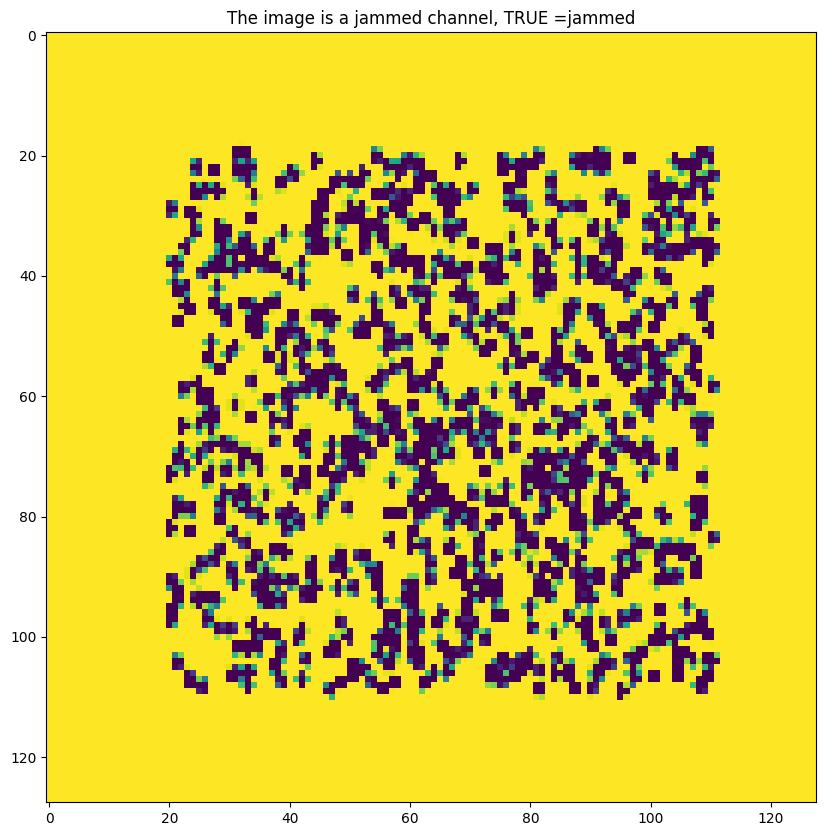

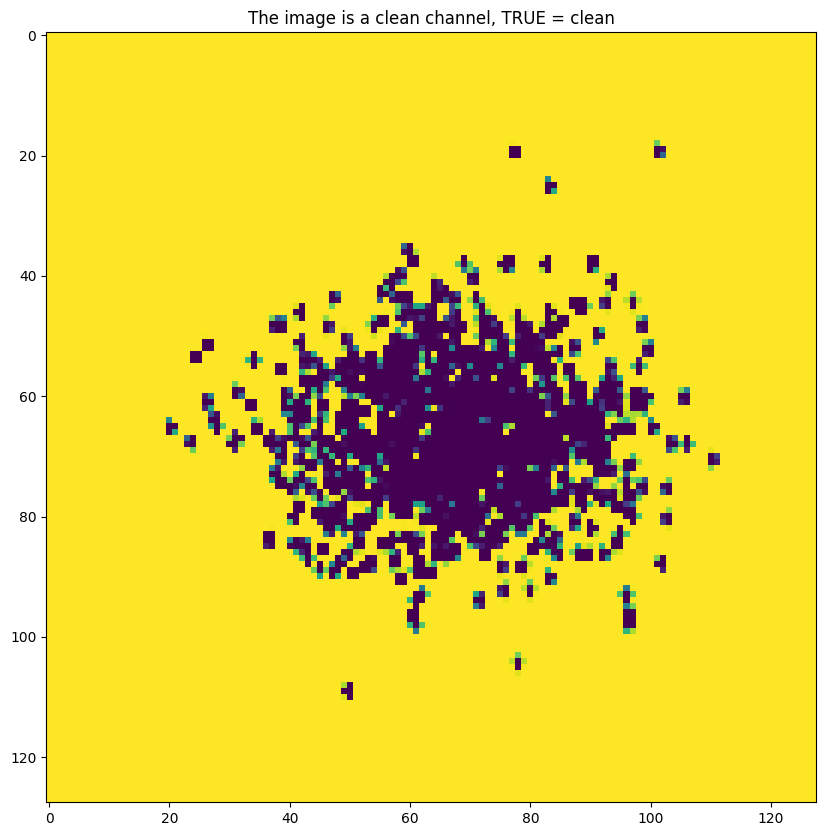

In [32]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num])

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num])

In [33]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0259


  0%|          | 1/800 [00:00<01:27,  9.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0297


  0%|          | 3/800 [00:00<01:12, 11.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0280


  1%|          | 5/800 [00:00<01:10, 11.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0259


  1%|          | 7/800 [00:00<01:09, 11.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0268


  1%|          | 9/800 [00:00<01:09, 11.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0256


  1%|▏         | 11/800 [00:00<01:11, 11.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0483


  2%|▏         | 13/800 [00:01<01:10, 11.12it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0286


  2%|▏         | 15/800 [00:01<01:12, 10.88it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0477


  2%|▏         | 17/800 [00:01<01:12, 10.82it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0293


  2%|▏         | 19/800 [00:01<01:12, 10.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


  3%|▎         | 21/800 [00:01<01:07, 11.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


  3%|▎         | 23/800 [00:02<01:03, 12.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


  3%|▎         | 25/800 [00:02<00:58, 13.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0277


  3%|▎         | 27/800 [00:02<00:55, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0475


  4%|▎         | 29/800 [00:02<00:54, 14.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


  4%|▍         | 31/800 [00:02<00:55, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


  4%|▍         | 33/800 [00:02<00:53, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


  4%|▍         | 35/800 [00:02<00:54, 14.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


  5%|▍         | 37/800 [00:02<00:51, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


  5%|▍         | 39/800 [00:03<00:49, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


  5%|▌         | 41/800 [00:03<01:29,  8.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0310


  5%|▌         | 43/800 [00:03<01:18,  9.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0254


  6%|▌         | 45/800 [00:03<01:12, 10.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0472


  6%|▌         | 47/800 [00:04<01:07, 11.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0293


  6%|▌         | 49/800 [00:04<01:05, 11.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0295


  6%|▋         | 51/800 [00:04<01:03, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


  7%|▋         | 53/800 [00:04<01:00, 12.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


  7%|▋         | 55/800 [00:04<00:58, 12.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0289


  7%|▋         | 57/800 [00:04<00:59, 12.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0481


  7%|▋         | 59/800 [00:04<01:01, 11.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0303


  8%|▊         | 61/800 [00:05<00:58, 12.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0489


  8%|▊         | 63/800 [00:05<00:58, 12.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0490


  8%|▊         | 65/800 [00:05<00:58, 12.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0250


  8%|▊         | 67/800 [00:05<00:58, 12.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0271


  9%|▊         | 69/800 [00:05<00:56, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0312


  9%|▉         | 71/800 [00:05<00:57, 12.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


  9%|▉         | 73/800 [00:06<00:56, 12.87it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0486


  9%|▉         | 75/800 [00:06<00:56, 12.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 10%|▉         | 77/800 [00:06<00:54, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0489


 10%|▉         | 79/800 [00:06<00:53, 13.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0259


 10%|█         | 81/800 [00:06<00:55, 12.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 10%|█         | 83/800 [00:06<00:55, 12.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0261


 11%|█         | 85/800 [00:06<00:55, 12.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0271


 11%|█         | 87/800 [00:07<00:54, 13.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0479


 11%|█         | 89/800 [00:07<00:55, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0266


 11%|█▏        | 91/800 [00:07<00:55, 12.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0483


 12%|█▏        | 93/800 [00:07<00:53, 13.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0492


 12%|█▏        | 95/800 [00:07<00:53, 13.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0263


 12%|█▏        | 97/800 [00:07<00:54, 12.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0248


 12%|█▏        | 99/800 [00:08<00:55, 12.71it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0297


 13%|█▎        | 101/800 [00:08<00:54, 12.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0482


 13%|█▎        | 103/800 [00:08<00:54, 12.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0255


 13%|█▎        | 105/800 [00:08<00:54, 12.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 13%|█▎        | 107/800 [00:08<00:53, 12.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0274


 14%|█▎        | 109/800 [00:08<00:52, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


 14%|█▍        | 111/800 [00:08<00:52, 13.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0485


 14%|█▍        | 113/800 [00:09<00:51, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0297


 14%|█▍        | 115/800 [00:09<00:50, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0475


 15%|█▍        | 117/800 [00:09<00:48, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0293


 15%|█▍        | 119/800 [00:09<00:48, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 15%|█▌        | 121/800 [00:09<00:49, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 15%|█▌        | 123/800 [00:09<00:48, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0473


 16%|█▌        | 125/800 [00:09<00:47, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 16%|█▌        | 127/800 [00:10<00:48, 14.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0257


 16%|█▌        | 129/800 [00:10<00:47, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 16%|█▋        | 131/800 [00:10<00:46, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 17%|█▋        | 133/800 [00:10<00:46, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 17%|█▋        | 135/800 [00:10<00:47, 14.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0269


 17%|█▋        | 137/800 [00:10<00:46, 14.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0285


 17%|█▋        | 139/800 [00:10<00:46, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 18%|█▊        | 141/800 [00:11<00:46, 14.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0292


 18%|█▊        | 143/800 [00:11<00:47, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0268


 18%|█▊        | 145/800 [00:11<00:46, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 18%|█▊        | 147/800 [00:11<00:46, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 19%|█▊        | 149/800 [00:11<00:46, 14.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 19%|█▉        | 151/800 [00:11<00:47, 13.80it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0284


 19%|█▉        | 153/800 [00:12<00:52, 12.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0476


 19%|█▉        | 155/800 [00:12<00:54, 11.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0495


 20%|█▉        | 157/800 [00:12<00:54, 11.76it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0246


 20%|█▉        | 159/800 [00:12<00:57, 11.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0242


 20%|██        | 161/800 [00:12<00:57, 11.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0266


 20%|██        | 163/800 [00:12<00:57, 11.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0484


 21%|██        | 165/800 [00:13<00:57, 11.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0489


 21%|██        | 167/800 [00:13<00:57, 11.08it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0287


 21%|██        | 169/800 [00:13<00:56, 11.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0283


 21%|██▏       | 171/800 [00:13<00:56, 11.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0487


 22%|██▏       | 173/800 [00:13<00:56, 11.05it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0474


 22%|██▏       | 175/800 [00:14<00:56, 11.03it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0302


 22%|██▏       | 177/800 [00:14<00:56, 11.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 22%|██▏       | 179/800 [00:14<00:55, 11.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0264


 23%|██▎       | 181/800 [00:14<00:51, 12.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 23%|██▎       | 183/800 [00:14<00:46, 13.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0239


 23%|██▎       | 185/800 [00:14<00:45, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 23%|██▎       | 187/800 [00:14<00:43, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0239


 24%|██▎       | 189/800 [00:15<00:42, 14.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 24%|██▍       | 191/800 [00:15<00:42, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 24%|██▍       | 193/800 [00:15<00:42, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 24%|██▍       | 195/800 [00:15<00:42, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 25%|██▍       | 197/800 [00:15<00:41, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


 25%|██▍       | 199/800 [00:15<00:40, 14.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0307


 25%|██▌       | 201/800 [00:15<00:40, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 25%|██▌       | 203/800 [00:15<00:41, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 26%|██▌       | 205/800 [00:16<00:41, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 26%|██▌       | 207/800 [00:16<00:42, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 26%|██▌       | 209/800 [00:16<00:40, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0483


 26%|██▋       | 211/800 [00:16<00:40, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 27%|██▋       | 213/800 [00:16<00:39, 14.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0486


 27%|██▋       | 215/800 [00:16<00:40, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 27%|██▋       | 217/800 [00:16<00:39, 14.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0490


 27%|██▋       | 219/800 [00:17<00:39, 14.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 28%|██▊       | 221/800 [00:17<00:39, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 28%|██▊       | 223/800 [00:17<00:40, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 28%|██▊       | 225/800 [00:17<00:40, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 28%|██▊       | 227/800 [00:17<00:39, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 29%|██▊       | 229/800 [00:17<00:39, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 29%|██▉       | 231/800 [00:17<00:39, 14.50it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0284


 29%|██▉       | 233/800 [00:18<00:38, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0265


 29%|██▉       | 235/800 [00:18<00:39, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 30%|██▉       | 237/800 [00:18<00:38, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 30%|██▉       | 239/800 [00:18<00:36, 15.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0481


 30%|███       | 241/800 [00:18<00:37, 14.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0482


 30%|███       | 243/800 [00:18<00:36, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 31%|███       | 245/800 [00:18<00:36, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 31%|███       | 247/800 [00:18<00:37, 14.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 31%|███       | 249/800 [00:19<00:38, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 31%|███▏      | 251/800 [00:19<00:38, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0486


 32%|███▏      | 253/800 [00:19<00:38, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0270


 32%|███▏      | 255/800 [00:19<00:38, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 32%|███▏      | 257/800 [00:19<00:37, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0261


 32%|███▏      | 259/800 [00:19<00:38, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0490


 33%|███▎      | 261/800 [00:19<00:37, 14.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0289


 33%|███▎      | 263/800 [00:20<00:37, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 33%|███▎      | 265/800 [00:20<00:38, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0263


 33%|███▎      | 267/800 [00:20<00:38, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0477


 34%|███▎      | 269/800 [00:20<00:37, 14.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 34%|███▍      | 271/800 [00:20<00:36, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 34%|███▍      | 273/800 [00:20<00:36, 14.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0476


 34%|███▍      | 275/800 [00:20<00:36, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


 35%|███▍      | 277/800 [00:21<00:36, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 35%|███▍      | 279/800 [00:21<00:36, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0495


 35%|███▌      | 281/800 [00:21<00:36, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 35%|███▌      | 283/800 [00:21<00:36, 14.00it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0276


 36%|███▌      | 285/800 [00:21<00:38, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0474


 36%|███▌      | 287/800 [00:21<00:38, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0290


 36%|███▌      | 289/800 [00:21<00:36, 13.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0478


 36%|███▋      | 291/800 [00:22<00:37, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 37%|███▋      | 293/800 [00:22<00:37, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0265


 37%|███▋      | 295/800 [00:22<00:37, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 37%|███▋      | 297/800 [00:22<00:36, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0487


 37%|███▋      | 299/800 [00:22<00:35, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 38%|███▊      | 301/800 [00:22<00:35, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0484


 38%|███▊      | 303/800 [00:22<00:35, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 38%|███▊      | 305/800 [00:23<00:35, 13.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0264


 38%|███▊      | 307/800 [00:23<00:35, 13.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 39%|███▊      | 309/800 [00:23<00:35, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 39%|███▉      | 311/800 [00:23<00:35, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 39%|███▉      | 313/800 [00:23<00:34, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0249


 39%|███▉      | 315/800 [00:23<00:33, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0477


 40%|███▉      | 317/800 [00:23<00:34, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0481


 40%|███▉      | 319/800 [00:24<00:33, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0476


 40%|████      | 321/800 [00:24<00:34, 13.98it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0261


 40%|████      | 323/800 [00:24<00:40, 11.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0290


 41%|████      | 325/800 [00:24<00:41, 11.43it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0289


 41%|████      | 327/800 [00:24<00:42, 11.02it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0288


 41%|████      | 329/800 [00:25<00:44, 10.69it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0265


 41%|████▏     | 331/800 [00:25<00:45, 10.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0480


 42%|████▏     | 333/800 [00:25<00:45, 10.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0491


 42%|████▏     | 335/800 [00:25<00:44, 10.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0280


 42%|████▏     | 337/800 [00:25<00:44, 10.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0486


 42%|████▏     | 339/800 [00:26<00:43, 10.63it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0265


 43%|████▎     | 341/800 [00:26<00:43, 10.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0476


 43%|████▎     | 343/800 [00:26<00:43, 10.48it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0301


 43%|████▎     | 345/800 [00:26<00:44, 10.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0473


 43%|████▎     | 347/800 [00:26<00:42, 10.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 44%|████▎     | 349/800 [00:26<00:38, 11.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0485


 44%|████▍     | 351/800 [00:27<00:36, 12.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 44%|████▍     | 353/800 [00:27<00:34, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0244


 44%|████▍     | 355/800 [00:27<00:34, 12.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


 45%|████▍     | 357/800 [00:27<00:33, 13.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0255


 45%|████▍     | 359/800 [00:27<00:32, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0482


 45%|████▌     | 361/800 [00:27<00:31, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 45%|████▌     | 363/800 [00:27<00:31, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 46%|████▌     | 365/800 [00:28<00:30, 14.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0261


 46%|████▌     | 367/800 [00:28<00:31, 13.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


 46%|████▌     | 369/800 [00:28<00:30, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0498


 46%|████▋     | 371/800 [00:28<00:29, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 47%|████▋     | 373/800 [00:28<00:29, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0485


 47%|████▋     | 375/800 [00:28<00:28, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0491


 47%|████▋     | 377/800 [00:28<00:28, 14.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 47%|████▋     | 379/800 [00:29<00:29, 14.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 48%|████▊     | 381/800 [00:29<00:29, 14.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0480


 48%|████▊     | 383/800 [00:29<00:29, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


 48%|████▊     | 385/800 [00:29<00:30, 13.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 48%|████▊     | 387/800 [00:29<00:29, 13.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0283


 49%|████▊     | 389/800 [00:29<00:29, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 49%|████▉     | 391/800 [00:29<00:28, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0492


 49%|████▉     | 393/800 [00:30<00:28, 14.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0271


 49%|████▉     | 395/800 [00:30<00:28, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0477


 50%|████▉     | 397/800 [00:30<00:28, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0475


 50%|████▉     | 399/800 [00:30<00:28, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 50%|█████     | 401/800 [00:30<00:27, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 50%|█████     | 403/800 [00:30<00:27, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0241


 51%|█████     | 405/800 [00:30<00:27, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 51%|█████     | 407/800 [00:30<00:27, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 51%|█████     | 409/800 [00:31<00:27, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0488


 51%|█████▏    | 411/800 [00:31<00:26, 14.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0286


 52%|█████▏    | 413/800 [00:31<00:26, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0265


 52%|█████▏    | 415/800 [00:31<00:26, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0482


 52%|█████▏    | 417/800 [00:31<00:26, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 52%|█████▏    | 419/800 [00:31<00:25, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 53%|█████▎    | 421/800 [00:31<00:25, 14.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0258


 53%|█████▎    | 423/800 [00:32<00:26, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0481


 53%|█████▎    | 425/800 [00:32<00:26, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0247


 53%|█████▎    | 427/800 [00:32<00:25, 14.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


 54%|█████▎    | 429/800 [00:32<00:25, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 54%|█████▍    | 431/800 [00:32<00:25, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0478


 54%|█████▍    | 433/800 [00:32<00:25, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0478


 54%|█████▍    | 435/800 [00:32<00:25, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 55%|█████▍    | 437/800 [00:33<00:25, 14.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0484


 55%|█████▍    | 439/800 [00:33<00:25, 14.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0266


 55%|█████▌    | 441/800 [00:33<00:24, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 55%|█████▌    | 443/800 [00:33<00:25, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0263


 56%|█████▌    | 445/800 [00:33<00:24, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0237


 56%|█████▌    | 447/800 [00:33<00:24, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 56%|█████▌    | 449/800 [00:33<00:24, 14.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 56%|█████▋    | 451/800 [00:34<00:24, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 57%|█████▋    | 453/800 [00:34<00:24, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0485


 57%|█████▋    | 455/800 [00:34<00:24, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0273


 57%|█████▋    | 457/800 [00:34<00:23, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0479


 57%|█████▋    | 459/800 [00:34<00:24, 14.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0488


 58%|█████▊    | 461/800 [00:34<00:23, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 58%|█████▊    | 463/800 [00:34<00:23, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0289


 58%|█████▊    | 465/800 [00:35<00:23, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 58%|█████▊    | 467/800 [00:35<00:23, 13.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0482


 59%|█████▊    | 469/800 [00:35<00:23, 14.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0481


 59%|█████▉    | 471/800 [00:35<00:22, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 59%|█████▉    | 473/800 [00:35<00:22, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0286


 59%|█████▉    | 475/800 [00:35<00:22, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 60%|█████▉    | 477/800 [00:35<00:22, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


 60%|█████▉    | 479/800 [00:36<00:22, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 60%|██████    | 481/800 [00:36<00:22, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 60%|██████    | 483/800 [00:36<00:22, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 61%|██████    | 485/800 [00:36<00:23, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0282


 61%|██████    | 487/800 [00:36<00:23, 13.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 61%|██████    | 489/800 [00:36<00:22, 13.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0296


 61%|██████▏   | 491/800 [00:36<00:24, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0482


 62%|██████▏   | 493/800 [00:37<00:25, 12.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0474


 62%|██████▏   | 495/800 [00:37<00:26, 11.41it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0282


 62%|██████▏   | 497/800 [00:37<00:28, 10.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0264


 62%|██████▏   | 499/800 [00:37<00:28, 10.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0260


 63%|██████▎   | 501/800 [00:37<00:27, 10.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0272


 63%|██████▎   | 503/800 [00:38<00:27, 10.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0230


 63%|██████▎   | 505/800 [00:38<00:26, 11.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0484


 63%|██████▎   | 507/800 [00:38<00:25, 11.36it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0487


 64%|██████▎   | 509/800 [00:38<00:26, 11.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0259


 64%|██████▍   | 511/800 [00:38<00:27, 10.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0491


 64%|██████▍   | 513/800 [00:39<00:27, 10.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0300


 64%|██████▍   | 515/800 [00:39<00:26, 10.71it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0285


 65%|██████▍   | 517/800 [00:39<00:25, 10.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 65%|██████▍   | 519/800 [00:39<00:24, 11.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0481


 65%|██████▌   | 521/800 [00:39<00:22, 12.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0474


 65%|██████▌   | 523/800 [00:39<00:21, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 66%|██████▌   | 525/800 [00:39<00:20, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0269


 66%|██████▌   | 527/800 [00:40<00:20, 13.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0491


 66%|██████▌   | 529/800 [00:40<00:19, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 66%|██████▋   | 531/800 [00:40<00:19, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0487


 67%|██████▋   | 533/800 [00:40<00:19, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0486


 67%|██████▋   | 535/800 [00:40<00:18, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0481


 67%|██████▋   | 537/800 [00:40<00:18, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0483


 67%|██████▋   | 539/800 [00:40<00:18, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 68%|██████▊   | 541/800 [00:41<00:18, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 68%|██████▊   | 543/800 [00:41<00:17, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0494


 68%|██████▊   | 545/800 [00:41<00:17, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0481


 68%|██████▊   | 547/800 [00:41<00:17, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0488


 69%|██████▊   | 549/800 [00:41<00:17, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0483


 69%|██████▉   | 551/800 [00:41<00:17, 14.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0282


 69%|██████▉   | 553/800 [00:41<00:17, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0480


 69%|██████▉   | 555/800 [00:42<00:17, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 70%|██████▉   | 557/800 [00:42<00:16, 14.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 70%|██████▉   | 559/800 [00:42<00:16, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0469


 70%|███████   | 561/800 [00:42<00:16, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 70%|███████   | 563/800 [00:42<00:16, 14.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0474


 71%|███████   | 565/800 [00:42<00:16, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 71%|███████   | 567/800 [00:42<00:16, 14.11it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0258


 71%|███████   | 569/800 [00:43<00:16, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0471


 71%|███████▏  | 571/800 [00:43<00:16, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 72%|███████▏  | 573/800 [00:43<00:16, 13.87it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0299


 72%|███████▏  | 575/800 [00:43<00:17, 12.77it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0263


 72%|███████▏  | 577/800 [00:43<00:18, 12.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


 72%|███████▏  | 579/800 [00:43<00:18, 11.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0290


 73%|███████▎  | 581/800 [00:44<00:18, 12.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0483


 73%|███████▎  | 583/800 [00:44<00:19, 11.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0260


 73%|███████▎  | 585/800 [00:44<00:19, 11.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0259


 73%|███████▎  | 587/800 [00:44<00:19, 11.18it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0482


 74%|███████▎  | 589/800 [00:44<00:19, 10.99it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0481


 74%|███████▍  | 591/800 [00:45<00:19, 10.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0482


 74%|███████▍  | 593/800 [00:45<00:20, 10.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0285


 74%|███████▍  | 595/800 [00:45<00:19, 10.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0258


 75%|███████▍  | 597/800 [00:45<00:19, 10.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0293


 75%|███████▍  | 599/800 [00:45<00:19, 10.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0486


 75%|███████▌  | 601/800 [00:45<00:19, 10.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0490


 75%|███████▌  | 603/800 [00:46<00:18, 10.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 76%|███████▌  | 605/800 [00:46<00:16, 11.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0477


 76%|███████▌  | 607/800 [00:46<00:15, 12.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 76%|███████▌  | 609/800 [00:46<00:14, 12.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 76%|███████▋  | 611/800 [00:46<00:14, 13.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0487


 77%|███████▋  | 613/800 [00:46<00:13, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 77%|███████▋  | 615/800 [00:46<00:13, 14.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0481


 77%|███████▋  | 617/800 [00:47<00:12, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 77%|███████▋  | 619/800 [00:47<00:12, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 78%|███████▊  | 621/800 [00:47<00:12, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0480


 78%|███████▊  | 623/800 [00:47<00:12, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 78%|███████▊  | 625/800 [00:47<00:12, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 78%|███████▊  | 627/800 [00:47<00:12, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0492


 79%|███████▊  | 629/800 [00:47<00:12, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0256


 79%|███████▉  | 631/800 [00:48<00:12, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0290


 79%|███████▉  | 633/800 [00:48<00:11, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0483


 79%|███████▉  | 635/800 [00:48<00:11, 14.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0296


 80%|███████▉  | 637/800 [00:48<00:11, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 80%|███████▉  | 639/800 [00:48<00:11, 14.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 80%|████████  | 641/800 [00:48<00:10, 14.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0481


 80%|████████  | 643/800 [00:48<00:11, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 81%|████████  | 645/800 [00:49<00:10, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 81%|████████  | 647/800 [00:49<00:10, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 81%|████████  | 649/800 [00:49<00:10, 14.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0284


 81%|████████▏ | 651/800 [00:49<00:10, 13.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0493


 82%|████████▏ | 653/800 [00:49<00:11, 12.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0289


 82%|████████▏ | 655/800 [00:49<00:11, 12.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0258


 82%|████████▏ | 657/800 [00:50<00:11, 11.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0481


 82%|████████▏ | 659/800 [00:50<00:12, 11.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0483


 83%|████████▎ | 661/800 [00:50<00:11, 11.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0476


 83%|████████▎ | 663/800 [00:50<00:11, 11.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0303


 83%|████████▎ | 665/800 [00:50<00:11, 11.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0291


 83%|████████▎ | 667/800 [00:50<00:11, 11.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0484


 84%|████████▎ | 669/800 [00:51<00:11, 11.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0261


 84%|████████▍ | 671/800 [00:51<00:11, 11.21it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0259


 84%|████████▍ | 673/800 [00:51<00:11, 10.89it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0285


 84%|████████▍ | 675/800 [00:51<00:11, 10.87it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0269


 85%|████████▍ | 677/800 [00:51<00:11, 10.92it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0476


 85%|████████▍ | 679/800 [00:52<00:11, 10.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0280


 85%|████████▌ | 681/800 [00:52<00:11, 10.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0479


 85%|████████▌ | 683/800 [00:52<00:10, 11.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0485


 86%|████████▌ | 685/800 [00:52<00:09, 12.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 86%|████████▌ | 687/800 [00:52<00:08, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0486


 86%|████████▌ | 689/800 [00:52<00:08, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0486


 86%|████████▋ | 691/800 [00:52<00:08, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 87%|████████▋ | 693/800 [00:53<00:07, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0309


 87%|████████▋ | 695/800 [00:53<00:07, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0489


 87%|████████▋ | 697/800 [00:53<00:07, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0323


 87%|████████▋ | 699/800 [00:53<00:07, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 88%|████████▊ | 701/800 [00:53<00:07, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0253


 88%|████████▊ | 703/800 [00:53<00:06, 14.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0483


 88%|████████▊ | 705/800 [00:53<00:06, 14.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0492


 88%|████████▊ | 707/800 [00:54<00:06, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0478


 89%|████████▊ | 709/800 [00:54<00:06, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 89%|████████▉ | 711/800 [00:54<00:06, 14.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0277


 89%|████████▉ | 713/800 [00:54<00:06, 13.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0479


 89%|████████▉ | 715/800 [00:54<00:06, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0297


 90%|████████▉ | 717/800 [00:54<00:05, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0493


 90%|████████▉ | 719/800 [00:54<00:05, 13.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 90%|█████████ | 721/800 [00:55<00:05, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 90%|█████████ | 723/800 [00:55<00:05, 13.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0484


 91%|█████████ | 725/800 [00:55<00:05, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0303


 91%|█████████ | 727/800 [00:55<00:05, 14.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 91%|█████████ | 729/800 [00:55<00:04, 14.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 91%|█████████▏| 731/800 [00:55<00:04, 14.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0483


 92%|█████████▏| 733/800 [00:55<00:04, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0482


 92%|█████████▏| 735/800 [00:56<00:04, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0278


 92%|█████████▏| 737/800 [00:56<00:04, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0491


 92%|█████████▏| 739/800 [00:56<00:04, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 93%|█████████▎| 741/800 [00:56<00:04, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0484


 93%|█████████▎| 743/800 [00:56<00:04, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 93%|█████████▎| 745/800 [00:56<00:03, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0491


 93%|█████████▎| 747/800 [00:56<00:03, 13.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0476


 94%|█████████▎| 749/800 [00:57<00:03, 13.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0303


 94%|█████████▍| 751/800 [00:57<00:03, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0285


 94%|█████████▍| 753/800 [00:57<00:03, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0266


 94%|█████████▍| 755/800 [00:57<00:03, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0478


 95%|█████████▍| 757/800 [00:57<00:03, 13.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 95%|█████████▍| 759/800 [00:57<00:02, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0487


 95%|█████████▌| 761/800 [00:57<00:02, 13.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0481


 95%|█████████▌| 763/800 [00:58<00:02, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0478


 96%|█████████▌| 765/800 [00:58<00:02, 13.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0478


 96%|█████████▌| 767/800 [00:58<00:02, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0480


 96%|█████████▌| 769/800 [00:58<00:02, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 96%|█████████▋| 771/800 [00:58<00:02, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0485


 97%|█████████▋| 773/800 [00:58<00:01, 14.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0480


 97%|█████████▋| 775/800 [00:58<00:01, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 97%|█████████▋| 777/800 [00:59<00:01, 13.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0290


 97%|█████████▋| 779/800 [00:59<00:01, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0479


 98%|█████████▊| 781/800 [00:59<00:01, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 98%|█████████▊| 783/800 [00:59<00:01, 14.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0257


 98%|█████████▊| 785/800 [00:59<00:01, 13.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0481


 98%|█████████▊| 787/800 [00:59<00:00, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0264


 99%|█████████▊| 789/800 [00:59<00:00, 14.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0481


 99%|█████████▉| 791/800 [01:00<00:00, 14.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0489


 99%|█████████▉| 793/800 [01:00<00:00, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 99%|█████████▉| 795/800 [01:00<00:00, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0474


100%|█████████▉| 797/800 [01:00<00:00, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


100%|█████████▉| 799/800 [01:00<00:00, 13.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0485


100%|██████████| 800/800 [01:00<00:00, 13.17it/s]


 The accuracy of our predictor is: 96.5 %


In [40]:
print("The accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor

The accuracy of the predictor is: 96.5 %


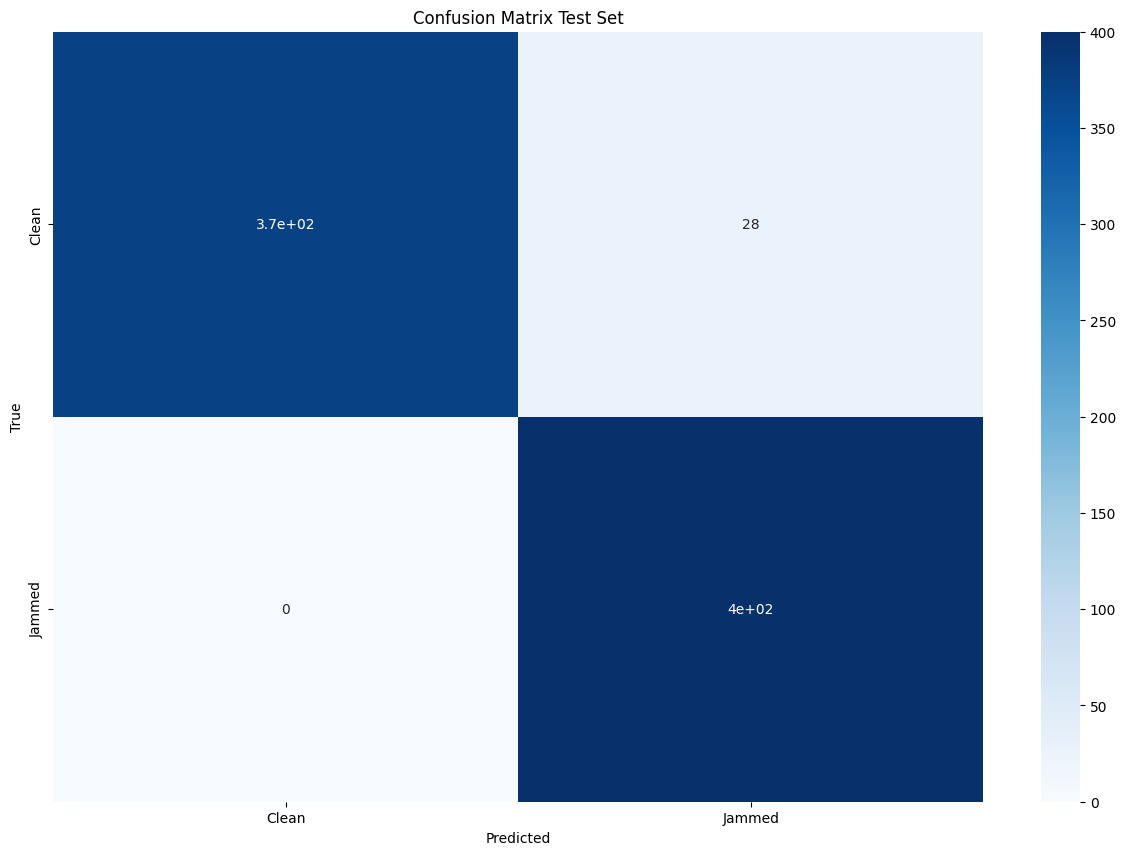

In [34]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor